In [109]:
from visualize import *

<AxesSubplot:>

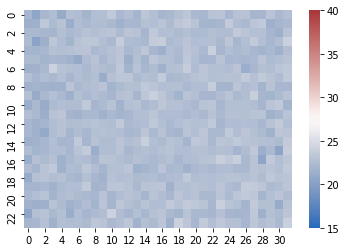

In [457]:
sns.heatmap(data[142,:,:,10] , cmap="vlag" , vmin=15 ,vmax=40)


In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scipy.stats as sc

In [414]:
n = 0.01
mean = np.zeros((235,24,32,16))
mean[0,:,:,0] = np.copy(data[0,:,:,0])
sigma = 0.4
alpha = 0.01
M = 0
gmean = np.zeros((235,24,32,16))
gp = np.zeros((235,24,32,16))
event = np.zeros((235,24,32,16))

for i in range(0,1):
    for j in range(0,1):
        for k in range(0,24):
            for l in range(0,32):
                event[i,k,l,j] = 1

for j in range(0,16):
    mean[0,:,:,0] = mean[0,:,:,0] + data[0,:,:,j]
for j in range(0,9):
    mean[0,:,:,0] = mean[0,:,:,0] + data[1,:,:,j]

mean[0,:,:,0] = mean[0,:,:,0]/25

fg = []
cnt = np.zeros((236,16))
bg = []
maxi = np.zeros((235,24,32,16))
mini = np.zeros((235,24,32,16))
mini[0,:,:,0] = data[0,:,:,0]
maxi[0,:,:,0] = data[0,:,:,0]
theta = 0.015
gamma = 0.2

In [415]:

for l in range(0,235):
    start = 0
    if l == 0:
        start = 1
    for k in range(start,16):
        for i in range(0,24):
            for j in range(0,32):
                if k==0:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l-1,i,j,15]*(1-alpha)    ## Mean if k==0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l-1,i,j,15] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l-1,i,j,15] , data[l,i,j,k])
                else:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l,i,j,k-1]*(1-alpha)     ## Mean if k!=0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l,i,j,k-1] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l,i,j,k-1] , data[l,i,j,k])

                gp[l,i,j,k] = gaussian_pdf(data[l,i,j,k] , sigma , mean[l,i,j,k])       ## Find the gaussian PDF 
                if gp[l,i,j,k]<n and data[l,i,j,k]>mean[l,i,j,k]:                       ## Process is foreground
                    event[l,i,j,k] = 0
                    fg.append((data[l,i,j,k] , mean[l,i,j,k]))
                    if k!=0:
                        mean[l,i,j,k] = mean[l,i,j,k-1]                                 ## Update the mean if the process is foreground
                    else:
                        mean[l,i,j,k] = mean[l-1,i,j,15]

                else:
                    event[l,i,j,k] = 1   
                    bg.append((data[l,i,j,k] , mean[l,i,j,k]))                          ## Process is Background

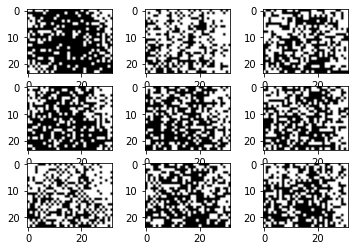

In [416]:
fig, axs = plt.subplots(3, 3)
axs[0,0].imshow(event[142,:,:,3] , cmap='Greys')
axs[1,0].imshow(event[142,:,:,4] , cmap='Greys')
axs[2,0].imshow(event[142,:,:,5] , cmap='Greys')
axs[0,1].imshow(event[142,:,:,6] , cmap='Greys')
axs[1,1].imshow(event[142,:,:,7] , cmap='Greys')
axs[2,1].imshow(event[142,:,:,8] , cmap='Greys')
axs[0,2].imshow(event[142,:,:,9] , cmap='Greys')
axs[1,2].imshow(event[142,:,:,10] , cmap='Greys')
axs[2,2].imshow(event[142,:,:,11] , cmap='Greys')

In [419]:
diff = np.zeros((235,24,32,16))
mrf_event = np.zeros((235,24,32,16))
mrf_event[0,:,:,0] = 1
for l in range(0,235):
    for k in range(0,16):
        for i in range(0,24):
            for j in range(0,32):
                qf = 0
                qb = 0
                ratio = gp[l,i,j,k]*25
                if i>0 and j>0:
                    if event[l,i-1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i>0:
                    if event[l,i-1,j,k] == 0:
                        qf = qf+1
                    else:
                        qb = qb+1
                if j<31 and i>0:
                    if event[l,i-1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j>0:
                    if event[l,i,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j<31:
                    if event[l,i,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j>0:
                    if event[l,i+1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23:
                    if event[l,i+1,j,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j<31:
                    if event[l,i+1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1

                mrf = theta * np.exp((qf-qb)/gamma)
                if ratio < mrf:
                    mrf_event[l,i,j,k] = 0
                    cnt[l,k] = cnt[l,k] + 1
                else:
                    mrf_event[l,i,j,k] = 1
                diff[l,i,j,k] = ratio-mrf


In [448]:
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] > 500:
            print(l,k)


0 0
131 5
131 6
131 7
131 8
131 9
131 10
131 11
131 12
131 13
131 14
140 4
140 5
140 6
140 7
140 8
140 9
140 10
140 11
140 12
140 13
140 14
140 15
141 0
141 13
141 14
141 15
142 5
142 6
142 9
142 11
142 14


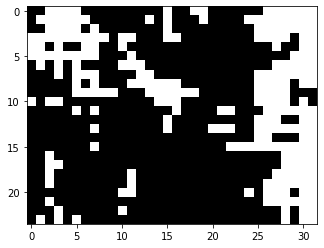

In [456]:
plt.imshow(mrf_event[142,:,:,10] , cmap='Greys')

In [34]:
def gaussian_pdf(x , sigma , mu):
    pdf1 = (1/(sigma*np.sqrt(2*np.pi)))
    pdf2 = np.exp(-0.5*((x-mu)/sigma)**2)
    return pdf1*pdf2

In [123]:
gaussian_pdf(20.2 , 0.4 , 21.9)

0.005072620143249392

In [125]:
sc.norm(21.56,0.4).pdf(20.35)

0.01027583454133161